# Stochastic Variational Sparse Gaussian Process (分類、白色化あり)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import SVSGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

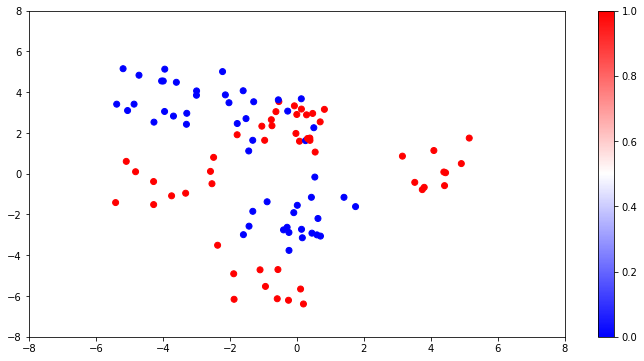

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
Z = X[:20, :].clone()
estimator = SVSGP(Z, 1, kernel, likelihood, whiten = True, subsample_size = 10)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_steps = 1000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % (n_steps / 10) == 0:
        print(loss)

7668.885654802207
5987.832269702414
2942.0342518639463
2633.2837709857276
2437.1720266608836
2081.151317138178
2040.96115508807
1566.0984839885248
598.1022403220461
1848.584126479982


---

## 推論結果

### 予測分布

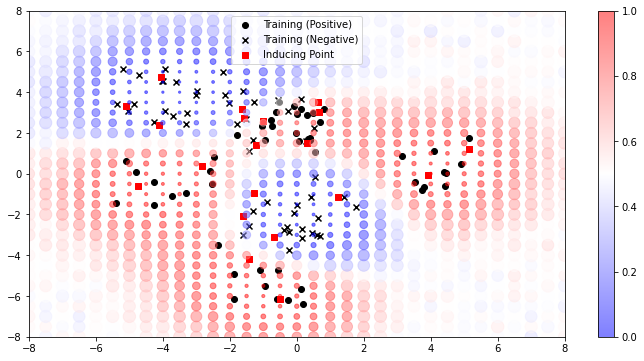

CPU times: user 21.4 s, sys: 895 ms, total: 22.3 s
Wall time: 6.05 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    s = ((pnew_std - pnew_std[:, 0].min()) / pnew_std[:, 0].std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.scatter(x = Xnew[:, 0], y = Xnew[:, 1], c = pnew_mean[:, 0], s = s, marker = "o", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.6483, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.Z

Parameter containing:
tensor([[-1.0213,  2.5717],
        [-5.1152,  3.3190],
        [ 5.1481,  1.1882],
        [-1.2254,  1.4291],
        [-2.8248,  0.3978],
        [-4.1206,  2.3865],
        [-1.4210, -4.1684],
        [-1.2749, -0.9557],
        [ 0.6779,  3.0096],
        [-1.5968, -2.0832],
        [ 0.6345,  3.5088],
        [-4.0429,  4.7321],
        [ 3.9291, -0.0473],
        [-1.6429,  3.1820],
        [-4.7326, -0.5841],
        [-1.5902,  2.7191],
        [-0.5042, -6.1223],
        [ 1.2299, -1.1457],
        [ 0.3040,  1.4995],
        [-0.6779, -3.1001]], requires_grad=True)

In [12]:
estimator.u_loc

Parameter containing:
tensor([[ 0.5459, -3.5580,  3.1291,  0.4311,  2.8010, -1.5936,  1.3557, -3.6578,
          1.7579, -0.3028, -2.4050, -3.0187,  2.4086, -2.9789,  2.8070,  0.4806,
          3.2533, -3.3737,  0.9405, -3.8021]], requires_grad=True)

In [13]:
estimator.u_cov

tensor([[[ 6.9157e-02, -6.9472e-03,  5.3372e-03, -2.0221e-02, -4.1883e-02,
          -4.4207e-02,  3.1009e-02, -4.4097e-03, -1.3626e-01,  6.0436e-02,
           2.5777e-02, -2.4051e-02,  1.1989e-02, -1.0500e-01,  2.8021e-02,
           3.0506e-02,  1.5373e-02,  8.8935e-03, -5.1913e-02, -1.6337e-02],
         [-6.9472e-03,  2.3636e-01, -1.9691e-02, -3.3361e-02,  1.6169e-03,
          -1.0954e-01, -7.7622e-02,  2.3253e-02,  7.6355e-02, -7.6968e-02,
          -2.7204e-02, -6.5850e-02,  3.6502e-02,  5.8397e-02, -7.8261e-02,
          -3.5839e-02,  5.1167e-02, -2.6942e-02, -1.1261e-01, -3.2596e-03],
         [ 5.3372e-03, -1.9691e-02,  2.7552e-01,  1.2254e-01, -8.4175e-02,
           2.6548e-02, -1.2230e-02,  1.5503e-02, -8.9742e-03,  6.2984e-02,
          -1.2446e-01,  3.6637e-02, -1.5552e-01, -3.2260e-02,  7.7424e-02,
           8.8446e-02, -4.3683e-02,  4.3336e-02,  1.2250e-01,  1.8148e-02],
         [-2.0221e-02, -3.3361e-02,  1.2254e-01,  2.2641e-01, -1.0821e-01,
          -1.4704e-02,